In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Base directory: where the SeismicDesignModule package is stored
base_directory = 'C:\\Users\\XINGQUAN GUAN\\Documents\\GitHub\\SeismicDesignModule'

# Postprocessing folder path
postprocessing_directory = base_directory + '\\Poseprocessing'

# Preprocessing folder path
preprocessing_directory = base_directory + '\\Preprocessing'

# Design results folder path
design_directory = base_directory + '\\BuildingData'

# Load the section database
os.chdir(base_directory)
with open('AllSectionDatabase.csv', 'r') as file:
    SECTION_DATABASE = pd.read_csv(file, header=0)

# Load the design sampling space
os.chdir(preprocessing_directory)
with open('DesignSheet2.csv', 'r') as file:
    DESIGN_SPACE = pd.read_csv(file, header=0)


def extract_member_results(target_IDs, file_name, is_reference):
    """
    :param target_IDs: a list which includes ID for buildings that we are interested.
    :param file_name: a string denoting the files that you want to read.
                      options: 'OptimalMemberSize.csv' or 'ConstructionSize.csv',
    :return members: a dictionary which includes three lists.
                     Each list has X element, where X is the number of total buildings that we are interested.
                     Each element is further a list with Y elements, where Y is the number of stories for each building.
    :isReference: a boolean variable to denote if the current buildings are reference buildings
                  (i.e. without any modification for design parameters)
                  If it is reference building, go to reference building directory, otherwise go to comparison building.
    """
    # Initialize three lists to store member sizes for a bunch of buildings
    beam = []
    exterior_column = []
    interior_column = []
    for ID in target_IDs:
        # Open the folder and read the target files
        if is_reference:
            target_path = design_directory + "\\SensitivityBuilding_" + str(ID)
        else:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID) + '_Drift'
        os.chdir(target_path)
        with open(file_name, 'r') as file:
            MemberSize = pd.read_csv(file, header=0)
        StoryNumber = MemberSize.shape[0]
        # Initialize three lists to store the member sizes for different stories in each building
        beam_per_building = []
        exterior_column_per_building = []
        interior_column_per_building = []
        # Loop all stories to read the sizes
        for story in range(0, StoryNumber):
            beam_per_building.append(MemberSize.loc[story, 'beam'])
            exterior_column_per_building.append(MemberSize.loc[story, 'exterior column'])
            interior_column_per_building.append(MemberSize.loc[story, 'interior column'])
        beam.append(beam_per_building)
        exterior_column.append(exterior_column_per_building)
        interior_column.append(interior_column_per_building)
    # Store all results into the dictionary
    members = {'beam': beam, 'exterior column': exterior_column, 'interior column': interior_column}
    return members


def extract_story_drift(target_IDs, file_name, is_reference):
    """
    This function is used to extract the story drifts from building design results.
    :param: target_IDs: :param target_IDs: a list which includes ID for buildings that we are interested.
    :param file_name: a string denoting the files that you want to read.
                      options: 'OptimalDrift.csv', 'ConstructionDrift.csv'
    :param is_reference: a boolean variable to denote whether the user wants to compute the final drift or not.
                           If true, the drift read from results should multiply with 5.5 and 1.1 
                           for RBS stiffness reduction.
                           If false, the drift is multiply with 5.5 and 1.04 to account for RBS stiffness reduction.
    :return: a list with X elements, where X is the number of buildings that we are interested.
             each element is further a list with Y elements. Y is the number of stories for each building.
    """
    # Initialize a list to store the function output
    story_drift = []
    for ID in target_IDs:
        drift_per_building = []
        if is_reference:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID)
        else:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID) + '_Drift'
        os.chdir(target_path)
        with open(file_name, 'r') as file1:
            StoryDrift = pd.read_csv(file1, header=0)
        RowNumber = StoryDrift.shape[0]
        for story in range(RowNumber):
            if is_reference:
                drift_per_building.append(StoryDrift.loc[story, 'story drift']*5.5*1.1*100)
            else:
                drift_per_building.append(StoryDrift.loc[story, 'story drift']*5.5*1.04*100)
        story_drift.append(drift_per_building)
    return story_drift


def extract_SCWB_ratio(target_IDs, file_name, is_reference):
    """
    This function extract the strong column weak beam ratio from design results.
    :param: target_IDs: :param target_IDs: a list which includes ID for buildings that we are interested.
    :param file_name: a string denoting the files that you want to read.
                      options: 'OptimalColumnBeamRatio.csv', 'ConstructionColumnBeamRatio.csv'
    :param is_reference: a boolean variable to denote whether the current building is a reference building.
                         If so, go into reference building directory. Otherwise, go into sensitivity building directory.
    :return column_beam_ratio: a dictionary which includes two lists for average interior joint and exterior joint.
                               Each list has X elements, where X is the number of buildings.
                               Each element is further a list with Y elements, where Y is the number of stories.
    """
    # Initialize two lists to store the ratios for interior and exterior joints respectively
    exterior_joint_ratio = []
    interior_joint_ratio = []
    for ID in target_IDs:
        # Initialize two lists to store the ratios for each story in a certain building
        interior_per_building = []
        exterior_per_building = []
        if is_reference:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID)
        else:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID) + '_Drift'
        os.chdir(target_path)
        with open(file_name, 'r') as file1:
            SCWBRatio = pd.read_csv(file1, header=0)
        RowNumber = SCWBRatio.shape[0]
        for story in range(RowNumber):
            if not np.isnan(SCWBRatio.iloc[story, 0]):
                exterior_per_building.append(SCWBRatio.iloc[story, 0])
                interior_per_building.append(np.mean(SCWBRatio.iloc[story, 1:3]))
            else:
                exterior_per_building.append(2.0)
                interior_per_building.append(1.0)
        exterior_joint_ratio.append(exterior_per_building)
        interior_joint_ratio.append(interior_per_building)
    column_beam_ratio = {'exterior joint': exterior_joint_ratio, 'interior joint': interior_joint_ratio}
    return column_beam_ratio

In [6]:
building_IDs = [22]
total_story = 19
file_name = 'ConstructionSize.csv'

# Load the design results for sensitivity buildings
members_reference = extract_member_results(building_IDs, file_name, True)
members_sensitivity = extract_member_results(building_IDs, file_name, False)
print('-------Reference Building:---------')
member_list = ['exterior column', 'interior column', 'beam']
for mn in member_list:
    print(mn, members_reference[mn])
print('-------Reference Building:---------')
for mn in member_list:
    print(mn, members_sensitivity[mn])

-------Reference Building:---------
exterior column [['W36X361', 'W36X361', 'W36X361', 'W36X361', 'W36X361', 'W36X361', 'W36X247', 'W36X247', 'W36X247', 'W36X232', 'W36X232', 'W36X232', 'W27X281', 'W27X281', 'W27X281', 'W14X550', 'W14X550', 'W14X550', 'W12X136']]
interior column [['W36X395', 'W36X395', 'W36X395', 'W36X361', 'W36X361', 'W36X361', 'W36X361', 'W36X361', 'W36X361', 'W33X387', 'W33X387', 'W33X387', 'W33X354', 'W33X354', 'W33X354', 'W33X263', 'W33X263', 'W33X263', 'W14X159']]
beam [['W36X282', 'W36X282', 'W36X282', 'W36X262', 'W36X262', 'W36X262', 'W36X262', 'W36X262', 'W36X262', 'W36X262', 'W36X262', 'W36X262', 'W36X210', 'W36X210', 'W36X210', 'W27X235', 'W27X235', 'W27X235', 'W21X93']]
-------Reference Building:---------
exterior column [['W33X291', 'W33X291', 'W33X291', 'W33X387', 'W33X387', 'W33X387', 'W33X291', 'W33X291', 'W33X291', 'W33X241', 'W33X241', 'W33X241', 'W27X281', 'W27X281', 'W27X281', 'W14X550', 'W14X550', 'W14X550', 'W12X136']]
interior column [['W36X395',

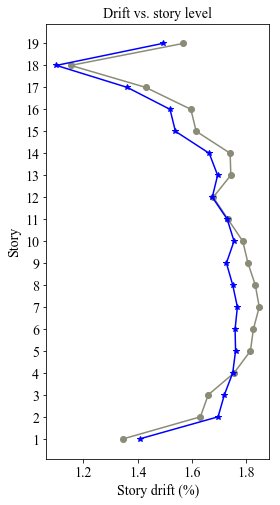

In [7]:
file_name = 'ConstructionDrift.csv'
FONTSIZE = 14
FIGSIZE = (4, 8)

drift_reference = extract_story_drift(building_IDs, file_name, True)
drift_sensitivity = extract_story_drift(building_IDs, file_name, False)

fig = plt.figure(figsize = FIGSIZE)
story_level = list(range(1, total_story+1))
for each in range(0, len(building_IDs)):
    plt.plot(drift_reference[each], story_level, marker='o', color=(139/255, 139/255, 120/255))
    plt.plot(drift_sensitivity[each], story_level, marker='*', color='blue')
plt.title('Drift vs. story level', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
plt.xlabel('Story drift (%)', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
plt.ylabel('Story', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
plt.xticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
plt.yticks(story_level, fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
plt.show()

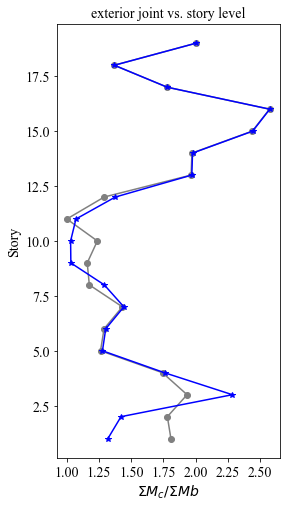

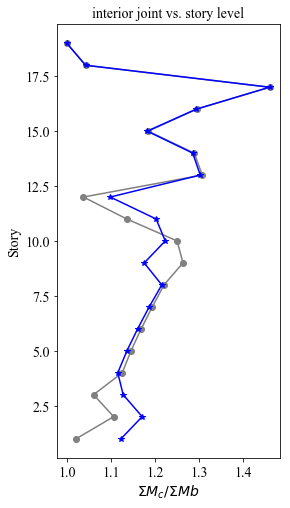

In [8]:
file_name = 'ConstructionColumnBeamRatio.csv'

SCWB_reference = extract_SCWB_ratio(building_IDs, file_name, True)
SCWB_sensitivity = extract_SCWB_ratio(building_IDs, file_name, False)
joint_names = ['exterior joint', 'interior joint']
for mn in joint_names:
    fig = plt.figure(figsize = FIGSIZE)
    for each in range(0, len(building_IDs)):
        plt.plot(SCWB_reference[mn][each], story_level, marker='o', color='grey')
        plt.plot(SCWB_sensitivity[mn][each], story_level, marker='*', color='blue')
    plt.title(mn+' vs. story level', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xlabel('$\Sigma M_c/\Sigma Mb$', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.ylabel('Story', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.yticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.show()